In [1]:
import copy
import itertools
import time
import math
import numpy as np

In [ ]:
# simplification
def f(L, maxl, cost, k, B):
    if k == 1:
        return ([L], B*max(0, L-maxl))
    if k == L:
        cost_ = max(1, maxl) * B
        for i in range(k-1):
         #   cost_ += cost[i][i]
            cost_ += cost[i]
        return ([1] * L, cost_)
    
    cost_best = float("inf")
    S_best = []
    for i in reversed(range(k, L)):
        S, cost_ = f(i, max(L-i, maxl), cost, k-1, B)
        cost_ += max(0, L-i-maxl)*B
        cost_ += cost[i-1]
        if cost_ < cost_best:
            cost_best = cost_
            S.append(L-i)
            S_best = S
    return S_best, cost_best

In [ ]:
L = 12
k = 8
cost = [2,1,1,3] * 12
f(L, 0, cost, k, 3)

In [6]:
def pipe_dp(L, cost_e, cost_c, k, B):
    # Generate all possible max length
    possible = [0]
    
    for i in range(1, L+1):
        ptr = 0
        while ptr + i <= L:
            possible.append(sum(cost_e[ptr:ptr+i]))
            ptr += 1
    
    possible = sorted(list(set(possible)))
    # print(possible)
    # trace will be a 3D list
    trace = []
    for i in range(L):
        outer = []
        for j in range(k):
            inner = []
            for m in range(len(possible)):
                inner.append(([],np.infty))
            outer.append(inner)
        trace.append(outer)
    
    # i: layer id, starting from 0
    # j: number of cut (=GPU-1)
    for i in range(L):
        for j in range(k):
            for m in range(len(possible)):
                if i+1 <= j: # invalid
                    pass
                else:
                    if j == 0: # base case: 0 cut
                        cur_sum = sum(cost_e[:i+1])
                        assert cur_sum in possible
                        trace[i][j][m] = ([i+1], (B-1) * max(0, cur_sum - possible[m]))
                    else:
                        cost_best = np.infty
                        S_best = []
                        for cut in range(j-1, i):
                            cur_sum = sum(cost_e[cut+1:i+1])
                            assert cur_sum in possible
                            S, cost_ = trace[cut][j-1][possible.index(max(cur_sum, possible[m]))]
                            #print(S, cost_)
                            cost_ += (B-1) * max(0, cur_sum - possible[m])
                            cost_ += cost_c[cut][j-1]
                            if cost_ < cost_best:
                                cost_best = cost_
                                S_ = copy.deepcopy(S)
                                S_.append(i-cut)
                                S_best = S_
                        trace[i][j][m] = (S_best, cost_best)
                        
    for i in range(L):
        for j in range(k):
            pass
            #print(i, j, trace[i][j])
    return trace[L-1][k-1][0]

def brute_force(L, cost_e, cost_c, k, B):
    best_S = []
    best_cost = np.infty
    ptr_done = [0] * (k-1)
    possible = list(itertools.combinations(range(L-1), k-1))
    for p in possible:
        p = list(p)
        p.append(L-1)
        lens = [sum(cost_e[:p[0]+1])]
        s = [p[0]+1]
        for i in range(len(p)-1):
            lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
            s.append(p[i+1]-p[i])     
        max_l = max(lens)
        cost = (B-1) * max_l
        for i in range(k-1):
            cost += cost_c[p[i]][i]
        if cost < best_cost:
            best_cost = cost
            best_S = s
    return best_S, best_cost

def uniform_split(L, cost_e, cost_c, k, B):
    per_stage = L // k
    
    s = [per_stage] * (k-1)
    s.append(L-sum(s))
    p = [s[0]-1]
    for i in range(1, k):
        p.append(p[i-1] + s[i])
    lens = [sum(cost_e[:p[0]+1])]
    for i in range(len(s)-1):
        lens.append(sum(cost_e[p[i]+1:p[i+1]+1]))
    max_l = max(lens)
    cost = (B-1) * max_l
    for i in range(k-1):
        cost += cost_c[p[i]][i]
    return s, cost

In [3]:
L = 4
k = 2
cost_e = [1,3,2,5]
cost_c = np.ones((L-1, k-1)) * 2
pipe_dp(L, cost_e, cost_c, k, 3)

0 0 [([1], 2), ([1], 0), ([1], 0), ([1], 0), ([1], 0), ([1], 0), ([1], 0), ([1], 0), ([1], 0), ([1], 0)]
0 1 [([], inf), ([], inf), ([], inf), ([], inf), ([], inf), ([], inf), ([], inf), ([], inf), ([], inf), ([], inf)]
1 0 [([2], 8), ([2], 6), ([2], 4), ([2], 2), ([2], 0), ([2], 0), ([2], 0), ([2], 0), ([2], 0), ([2], 0)]
1 1 [([1, 1], 8.0), ([1, 1], 6.0), ([1, 1], 4.0), ([1, 1], 2.0), ([1, 1], 2.0), ([1, 1], 2.0), ([1, 1], 2.0), ([1, 1], 2.0), ([1, 1], 2.0), ([1, 1], 2.0)]
2 0 [([3], 12), ([3], 10), ([3], 8), ([3], 6), ([3], 4), ([3], 2), ([3], 0), ([3], 0), ([3], 0), ([3], 0)]
2 1 [([2, 1], 10.0), ([2, 1], 8.0), ([2, 1], 6.0), ([2, 1], 4.0), ([2, 1], 2.0), ([1, 2], 2.0), ([1, 2], 2.0), ([1, 2], 2.0), ([1, 2], 2.0), ([1, 2], 2.0)]
3 0 [([4], 22), ([4], 20), ([4], 18), ([4], 16), ([4], 14), ([4], 12), ([4], 10), ([4], 8), ([4], 2), ([4], 0)]
3 1 [([3, 1], 14.0), ([3, 1], 12.0), ([3, 1], 10.0), ([3, 1], 8.0), ([3, 1], 6.0), ([3, 1], 4.0), ([3, 1], 2.0), ([2, 2], 2.0), ([1, 3], 2.0), ([

([3, 1], 14.0)

In [4]:
test_list = [(12, 4), (24, 4), (24,8), (24, 12), (36, 8)]

In [9]:
# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"homo us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

homo dp L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.011948347091674805
homo bf L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.0019943714141845703
homo us L=12 k=4 is [3, 3, 3, 3], minimum cost 12.0. Took time 0.0
homo dp L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.10673046112060547
homo bf L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.01792764663696289
homo us L=24 k=4 is [6, 6, 6, 6], minimum cost 18.0. Took time 0.0
homo dp L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.21442461013793945
homo bf L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 4.285534381866455
homo us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.0
homo dp L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 0.27722954750061035
homo bf L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 26.0. Took time 32.76035165786743
homo us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [10]:
# hetergeneous test
for L, k in test_list:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    print(f"hete bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [3, 3, 2, 4], minimum cost 65. Took time 0.046866655349731445
hete bf L=12 k=4 is [3, 3, 2, 4], minimum cost 65. Took time 0.001994609832763672
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 65. Took time 0.0
hete dp L=24 k=4 is [6, 7, 7, 4], minimum cost 109. Took time 0.6502325534820557
hete bf L=24 k=4 is [6, 7, 7, 4], minimum cost 109. Took time 0.017981767654418945
hete us L=24 k=4 is [6, 6, 6, 6], minimum cost 114. Took time 0.0
hete dp L=24 k=8 is [3, 3, 2, 3, 3, 3, 4, 3], minimum cost 93. Took time 1.4241876602172852
hete bf L=24 k=8 is [3, 3, 2, 3, 3, 3, 4, 3], minimum cost 93. Took time 4.182834148406982
hete us L=24 k=8 is [3, 3, 3, 3, 3, 3, 3, 3], minimum cost 98. Took time 0.0
hete dp L=24 k=12 is [2, 3, 1, 1, 2, 1, 2, 2, 3, 3, 1, 3], minimum cost 104. Took time 1.7802371978759766
hete bf L=24 k=12 is [2, 3, 1, 1, 2, 1, 2, 2, 3, 3, 1, 3], minimum cost 104. Took time 31.874720811843872
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum co

In [7]:
test_list_large = [(12, 4), (24, 12), (36, 8), (36, 12), (48,12), (48, 24), (64, 12), (64, 16), (128, 32), (128, 12), (128, 50)]
for L, k in test_list_large:
    cost_e = np.random.randint(low=5,high=10,size=L)
    cost_c = np.random.randint(low=5,high=10,size=(L-1,k-1))
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    print(f"hete dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")
    time_s = time.time()
    res = uniform_split(L, cost_e, cost_c, k, 3)
    print(f"hete us L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time.time() - time_s}")

hete dp L=12 k=4 is [2, 3, 3, 4], minimum cost 66. Took time 0.04785466194152832
hete us L=12 k=4 is [3, 3, 3, 3], minimum cost 70. Took time 0.000997304916381836
hete dp L=24 k=12 is [3, 3, 1, 3, 1, 2, 1, 3, 3, 1, 1, 2], minimum cost 102. Took time 1.8829903602600098
hete us L=24 k=12 is [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], minimum cost 107. Took time 0.0


KeyboardInterrupt: 

In [19]:
from matplotlib import pyplot as plt

test_list = [(16,8), (17, 8), (18,8), (19,8), (20, 8), (21,8), (22,8), (23, 8),(24,8)]
dp_time = []
bf_time = []

# homogeneous test
for L, k in test_list:
    cost_e = np.ones(L)
    cost_c = np.ones((L-1, k-1)) * 2
    time_s = time.time()
    res = pipe_dp(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    dp_time.append(time_elapsed)
    print(f"homo dp L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")
    time_s = time.time()
    res = brute_force(L, cost_e, cost_c, k, 3)
    time_elapsed = time.time() - time_s
    bf_time.append(time_elapsed)
    print(f"homo bf L={L} k={k} is {res[0]}, minimum cost {res[1]}. Took time {time_elapsed}")

homo dp L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.05189323425292969
homo bf L=16 k=8 is [2, 2, 2, 2, 2, 2, 2, 2], minimum cost 18.0. Took time 0.1096792221069336
homo dp L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.06781816482543945
homo bf L=17 k=8 is [1, 1, 1, 2, 3, 3, 3, 3], minimum cost 20.0. Took time 0.20744705200195312
homo dp L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.08078145980834961
homo bf L=18 k=8 is [1, 1, 1, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.34108781814575195
homo dp L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.08978819847106934
homo bf L=19 k=8 is [1, 1, 2, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.5295546054840088
homo dp L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.11272788047790527
homo bf L=20 k=8 is [1, 1, 3, 3, 3, 3, 3, 3], minimum cost 20.0. Took time 0.8706696033477783
homo dp L=21 k=8 is [1, 2, 3, 3, 3, 3, 3, 3], minimum

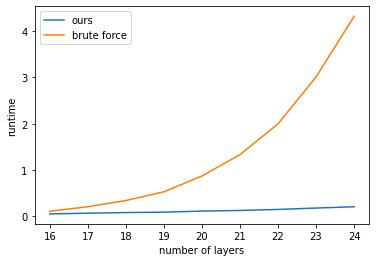

In [26]:
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], dp_time, label="ours")
plt.plot([16,17, 18, 19, 20, 21, 22, 23, 24], bf_time, label="brute force")
plt.xlabel("number of layers")
plt.ylabel("runtime")
plt.legend(loc="best")